## 25th June 2025
## TCGA Data Folder Exploration 
## 

In [1]:
#install libraries
#!pip install pandas scikit-learn numpy matplot

In [3]:
#import libraries
#data handling
import pandas as pd #to manipulate data
import os #to manipulate working directory
import numpy as np

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

#Feature selection
from sklearn.feature_selection import mutual_info_classif

#Classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

#performance metrics 
from sklearn.metrics import balanced_accuracy_score,f1_score,precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



In [5]:
# Read the Data
folder_path = r'C:\Users\peace\OneDrive\Desktop\Project\DataFile\prad_tcga_pan_can_atlas_2018\prad_tcga_pan_can_atlas_2018'
# Change the working directory
os.chdir(folder_path)

# Check the working directory
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\peace\OneDrive\Desktop\Project\DataFile\prad_tcga_pan_can_atlas_2018\prad_tcga_pan_can_atlas_2018


In [9]:
txt_files = [f for f in os.listdir() if f.endswith('.txt')]   #iterates through the file list for files that ends with ".txt"
print("Files found:", txt_files)

# Create an empty Dictionary to store the file as DataFrames
dataframes = {}

# Load each file
for file in txt_files:              #iterate through each ".txt" file 
    try:                            #use try to load file to avoid error into dataframe 
        df = pd.read_csv(file, sep='\t', low_memory=False)   #load into panda df
        key_name = os.path.splitext(file)[0]  #split filename "cna.txt" > "cna" "txt" & select the first part[0] to assign as key name 
        dataframes[key_name] = df             #store df into the dictionary using file name as key
        print(f"{file} loaded successfully. Shape: {df.shape}")
    except Exception as e:                    
        print(f"Failed to load {file}: {e}")

Files found: ['data_armlevel_cna.txt', 'data_clinical_patient.txt', 'data_clinical_sample.txt', 'data_clinical_supp_hypoxia.txt', 'data_cna.txt', 'data_genetic_ancestry.txt', 'data_gene_panel_matrix.txt', 'data_log2_cna.txt', 'data_methylation_hm27_hm450_merged.txt', 'data_mrna_seq_v2_rsem.txt', 'data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt', 'data_mrna_seq_v2_rsem_zscores_ref_diploid_samples.txt', 'data_mrna_seq_v2_rsem_zscores_ref_normal_samples.txt', 'data_mutations.txt', 'data_resource_definition.txt', 'data_resource_patient.txt', 'data_rppa.txt', 'data_rppa_zscores.txt', 'data_sv.txt', 'data_timeline_sample_acquisition.txt', 'data_timeline_status.txt', 'data_timeline_treatment.txt', 'meta_armlevel_cna.txt', 'meta_clinical_patient.txt', 'meta_clinical_sample.txt', 'meta_cna.txt', 'meta_cna_hg19_seg.txt', 'meta_genetic_ancestry.txt', 'meta_gene_panel_matrix.txt', 'meta_log2_cna.txt', 'meta_methylation_hm27_hm450_merged.txt', 'meta_mrna_seq_v2_rsem.txt', 'meta_mrna_seq_v2_rsem_z

In [11]:
#GENE and Treatment Identification

#Z-score normalized RNA-Seq data showing gene expression levels across patient samples,
#used to analyze MAPK pathway activity and treatment response.
mrna_df = dataframes['data_mrna_seq_v2_rsem_zscores_ref_all_samples']
print("Shape:", mrna_df.shape)
print("First 10 column names:\n", mrna_df.columns.tolist()[:10])

#Load and assess Copy Number Alteration (CNA) data 
cna_df = dataframes['data_log2_cna']
print("Shape:", cna_df.shape)
print("First 10 column names:\n", cna_df.columns.tolist()[:10])

#timeline treatment
treatment_df = dataframes['data_timeline_treatment']
print(treatment_df.columns.tolist())

Shape: (20531, 495)
First 10 column names:
 ['Hugo_Symbol', 'Entrez_Gene_Id', 'TCGA-2A-A8VL-01', 'TCGA-2A-A8VO-01', 'TCGA-2A-A8VT-01', 'TCGA-2A-A8VV-01', 'TCGA-2A-A8VX-01', 'TCGA-2A-A8W1-01', 'TCGA-2A-A8W3-01', 'TCGA-2A-AAYF-01']
Shape: (25128, 491)
First 10 column names:
 ['Hugo_Symbol', 'Entrez_Gene_Id', 'TCGA-2A-A8VL-01', 'TCGA-2A-A8VO-01', 'TCGA-2A-A8VT-01', 'TCGA-2A-A8VV-01', 'TCGA-2A-A8VX-01', 'TCGA-2A-A8W1-01', 'TCGA-2A-A8W3-01', 'TCGA-2A-AAYF-01']
['PATIENT_ID', 'START_DATE', 'STOP_DATE', 'EVENT_TYPE', 'TREATMENT_TYPE', 'TREATMENT_SUBTYPE', 'AGENT', 'NUMBER_OF_CYCLES', 'PRESCRIBED_DOSE', 'PRESCRIBED_DOSE_UNITS', 'REGIMEN_NUMBER', 'REGIMEN_INDICATION', 'REGIMEN_INDICATION_NOTES', 'MEASURE_OF_RESPONSE', 'CLINICAL_TRIAL_DRUG_CLASSIFICATION', 'ROUTE_OF_ADMINISTRATION', 'ROUTE_OF_ADMINISTRATION-2', 'THERAPY_ONGOING', 'TOTAL_DOSE', 'TOTAL_DOSE_UNITS', 'TX_ON_CLINICAL_TRIAL', 'ANATOMIC_TREATMENT_SITE', 'COURSE_NUMBER', 'NUMBER_OF_FRACTIONS', 'RADIATION_DOSAGE', 'RADIATION_TREATMENT_ON

In [13]:
#Measure of treatment response is the target variable
print(treatment_df['MEASURE_OF_RESPONSE'].value_counts(dropna=False))

MEASURE_OF_RESPONSE
NaN                                 77
complete response                   76
partial response                    22
stable disease                      16
clinical progressive disease        10
radiographic progressive disease     7
Name: count, dtype: int64


In [15]:
## Rearranging the data 
#Setting gene names as index and transpose 

mrna_trans_df = mrna_df

#Transpose the mRNA data
mrna_trans_df = mrna_df.set_index(mrna_df.columns[0]).T    #set index column as the new index column and transpose

#Reset the index to get the Sample_ID
mrna_trans_df.reset_index(inplace= True)             #moves the index to a new column 
mrna_trans_df.rename(columns= {'index': 'Sample_ID'}, inplace=True)  #rename the index as 'sample_ID' for clarity 

#Trimming sample IDs to first 12 chars to match patient-level ID format
mrna_trans_df['PATIENT_ID'] = mrna_trans_df['Sample_ID'].str[:12]      #Take the first 12 characters of the sample_ID to create a 'PATIENT_ID' column

print("Transposed mRNA shape:",mrna_trans_df.shape)


#set gene names as index and transpose the CNA data 
cna_trans_df =cna_df 

#Transpose the CNA Ddata
cna_trans_df = cna_df.set_index(cna_df.columns[0]).T

#Reset index to get Sample_ID
cna_trans_df.reset_index(inplace= True)
cna_trans_df.rename(columns={'index': 'Sample_ID'}, inplace=True)

#Triming sample IDs to first 12 chars to match patient-level ID format
cna_trans_df['PATIENT_ID'] = cna_trans_df['Sample_ID'].str[:12]

print("Transposed CNA shape:", cna_trans_df.shape)






Transposed mRNA shape: (494, 20533)
Transposed CNA shape: (490, 25130)


### Preparing the MAPK Gene List


In [17]:
mapk_genes = [
    'ARAF', 'BRAF', 'HRAS', 'KRAS', 'NRAS', 'RAF1',
    'MAP2K1', 'MAP2K2', 'MAPK1', 'MAPK3',
    'MAPK8', 'MAPK9', 'MAPK10', 'MAPK11', 'MAPK12',
    'MAPK13', 'MAPK14', 'MAPK15',
    'DUSP1', 'PTEN', 'EGFR', 'KSR1', 'GRB2', 'SOS1', 'FOS', 'JUN', 'MAP3K1', 'MAP3K2',
    'DUSP4', 'DUSP6', 'RASA1', 'SPRY2', 'FGFR1', 'FGFR2'
]  # there are 34 MAPK genes

#checking for absent or present gene in the MAPK dataset
present_genes = [gene for gene in mapk_genes if gene in mrna_trans_df.columns]
missing_genes = [gene for gene in mapk_genes if gene not in mrna_trans_df.columns]

print("MAPK genes found in data:", present_genes)
print("MAPK genes missing from data:", missing_genes)

MAPK genes found in data: ['ARAF', 'BRAF', 'HRAS', 'KRAS', 'NRAS', 'RAF1', 'MAP2K1', 'MAP2K2', 'MAPK1', 'MAPK3', 'MAPK8', 'MAPK9', 'MAPK10', 'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14', 'MAPK15', 'DUSP1', 'PTEN', 'EGFR', 'KSR1', 'GRB2', 'SOS1', 'FOS', 'JUN', 'MAP3K1', 'MAP3K2', 'DUSP4', 'DUSP6', 'RASA1', 'SPRY2', 'FGFR1', 'FGFR2']
MAPK genes missing from data: []


The result shows that all 34 MAPK pathway genes are present in the mRNA dataset. This confirms that the dataset includes expression profiles for key genes involved in the MAPK signaling pathway, which are relevant for studying treatment resistance in prostate cancer. With these genes available, they can now be extracted as input features for training the machine learning model. The analysis will have biologically significant biomarkers (MAPK) associated with treatment outcomes.

### Preparing the MAPK Gene Data Set
Selected the MAPK genes that will be used as the train features for the MAPK genes. The dataset from the mrna data and then the cna data

In [19]:
mapk_mrna_df = mrna_trans_df[['PATIENT_ID'] + mapk_genes]
print("MAPK gene expression data shape:", mapk_mrna_df.shape)
print(mapk_mrna_df.head())

#The cna data 
mapk_cna_df = cna_trans_df[['PATIENT_ID'] + mapk_genes]
mapk_cna_df = mapk_cna_df.rename(columns = {gene: f"{gene}_cna" for gene in mapk_genes})

print("\n MAPK gene expression data shape:", mapk_cna_df.shape)
print(mapk_cna_df.head())

MAPK gene expression data shape: (494, 35)
Hugo_Symbol    PATIENT_ID      ARAF      BRAF       HRAS       KRAS  \
0            Entrez_Gene_  369.0000  673.0000  3265.0000  3845.0000   
1            TCGA-2A-A8VL   -0.0610   -1.5311     0.2898    -1.0884   
2            TCGA-2A-A8VO    0.8460   -1.1840     0.7671    -0.3870   
3            TCGA-2A-A8VT   -0.2260    1.1105     0.1345    -1.3060   
4            TCGA-2A-A8VV   -1.0212    0.1110    -0.0572    -0.5366   

Hugo_Symbol       NRAS       RAF1     MAP2K1     MAP2K2      MAPK1  ...  \
0            4893.0000  5894.0000  5604.0000  5605.0000  5594.0000  ...   
1              -1.0793    -0.3868     0.9475     0.9211     0.0663  ...   
2              -0.0213    -1.0856     0.7794     1.1497    -0.5735  ...   
3               0.4124     2.8254     1.2351    -0.4458    -0.4918  ...   
4              -0.8571     0.0795     0.5959     0.5107    -0.2450  ...   

Hugo_Symbol        FOS        JUN     MAP3K1      MAP3K2      DUSP4  \
0       

### Prepare the Target Dataset
Treatment was set as  the target 

In [21]:
#"Patiient id" is the primary key for the table. "Measure of response" is the target variable
target_df = treatment_df[['PATIENT_ID','MEASURE_OF_RESPONSE','TREATMENT_TYPE']]

print(target_df.columns.tolist())
print("target dataframe shape:", target_df.shape)

['PATIENT_ID', 'MEASURE_OF_RESPONSE', 'TREATMENT_TYPE']
target dataframe shape: (208, 3)


### Join MAPK Gene and Response  
To prepare the dataset for machine learning, a join operation was used between the MAPK gene expression data and the treatment response labels. Both datasets contain a common identifier "PATIENT_ID2,which was used as the primary key for merging both data.
An inner join was applied to retain only patients who had both gene expression profiles and recorded tretament outcomes. This stepp was used to ensure the resulting dataset is clean and well-structured, contaonong only complete cases suitable for suppervised learning and prsictive model.

In [43]:
#Merging the mRNA (mapk_mrna_df) and CNA (mapk_cna_df) data 
mapk_combined = mapk_mrna_df.merge(mapk_cna_df, on='PATIENT_ID', how='inner')

# Merging with response variable (target_df)
merged_df = mapk_combined.merge(target_df, on='PATIENT_ID', how='inner')

#View the merged data sets 
print("Final merged DataFrame shape:", merged_df.shape)
print(merged_df.head())

#Export
merged_df.to_csv('merged_df.csv', index= False)

Final merged DataFrame shape: (208, 71)
     PATIENT_ID    ARAF    BRAF    HRAS    KRAS    NRAS    RAF1  MAP2K1  \
0  TCGA-2A-A8VT -0.2260  1.1105  0.1345 -1.3060  0.4124  2.8254  1.2351   
1  TCGA-2A-A8VT -0.2260  1.1105  0.1345 -1.3060  0.4124  2.8254  1.2351   
2  TCGA-4L-AA1F -1.2337  0.0838 -0.6688  0.6233  1.0952 -0.9766 -1.0624   
3  TCGA-CH-5741 -0.0553 -0.1687 -0.5289 -0.0316 -0.0179  0.8442  0.9456   
4  TCGA-CH-5751 -1.5708  3.5178 -2.1029  2.1736  2.3636  1.1228 -0.4158   

   MAP2K2   MAPK1  ...  MAP3K1_cna  MAP3K2_cna  DUSP4_cna  DUSP6_cna  \
0 -0.4458 -0.4918  ...      -0.285       0.036     -1.070      0.000   
1 -0.4458 -0.4918  ...      -0.285       0.036     -1.070      0.000   
2 -1.0342  0.1173  ...      -0.144       0.084     -0.256      0.072   
3 -0.8248 -0.8615  ...       0.000      -0.006      0.004     -0.002   
4 -1.4598  0.5000  ...      -0.731      -0.015     -0.668     -0.203   

   RASA1_cna  SPRY2_cna  FGFR1_cna  FGFR2_cna  MEASURE_OF_RESPONSE  \
0     

### Importing Dataset to Environment from the Working Directory


In [45]:
df =pd.read_csv('merged_df.csv')
print("Merged DataFrame shape:", df.shape)
df.head()

Merged DataFrame shape: (208, 71)


,PATIENT_ID,ARAF,BRAF,HRAS,KRAS,NRAS,RAF1,MAP2K1,MAP2K2,MAPK1,...,MAP3K1_cna,MAP3K2_cna,DUSP4_cna,DUSP6_cna,RASA1_cna,SPRY2_cna,FGFR1_cna,FGFR2_cna,MEASURE_OF_RESPONSE,TREATMENT_TYPE
0,TCGA-2A-A8VT,-0.2260,1.1105,0.1345,-1.3060,0.4124,2.8254,1.2351,-0.4458,-0.4918,...,-0.285,0.036,-1.070,0.000,-0.285,0.070,-1.070,-0.247,stable disease,Hormone Therapy
1,TCGA-2A-A8VT,-0.2260,1.1105,0.1345,-1.3060,0.4124,2.8254,1.2351,-0.4458,-0.4918,...,-0.285,0.036,-1.070,0.000,-0.285,0.070,-1.070,-0.247,stable disease,Radiation Therapy
2,TCGA-4L-AA1F,-1.2337,0.0838,-0.6688,0.6233,1.0952,-0.9766,-1.0624,-1.0342,0.1173,...,-0.144,0.084,-0.256,0.072,-0.144,-0.308,-0.256,-0.238,NaN,Hormone Therapy
3,TCGA-CH-5741,-0.0553,-0.1687,-0.5289,-0.0316,-0.0179,0.8442,0.9456,-0.8248,-0.8615,...,0.000,-0.006,0.004,-0.002,0.000,-0.701,0.004,-0.000,complete response,Hormone Therapy
4,TCGA-CH-5751,-1.5708,3.5178,-2.1029,2.1736,2.3636,1.1228,-0.4158,-1.4598,0.5000,...,-0.731,-0.015,-0.668,-0.203,-0.111,-0.425,0.844,-0.151,NaN,Hormone Therapy


### Clean Data Frame
#### Wraggle Function

In [47]:
def wrangler(data):
    """
    Drops rows with missing MEASURE_OF_RESPONSE orPATIENT_ID
    Returns cleaned Dataframe.
    """
    data =data.dropna(subset=['MEASURE_OF_RESPONSE'])
    #dropping the patient_id colummn 
    data = data.drop(columns=['PATIENT_ID'])
    return data

In [49]:
# Clean the data using wrangler function 
df_clean = wrangler(df)

#Display the shape of the clean Dataframe
print("Cleanedd DataFrame shape:", df_clean.shape)

#View the first few rows 
df_clean.head()


Cleanedd DataFrame shape: (131, 70)


,ARAF,BRAF,HRAS,KRAS,NRAS,RAF1,MAP2K1,MAP2K2,MAPK1,MAPK3,...,MAP3K1_cna,MAP3K2_cna,DUSP4_cna,DUSP6_cna,RASA1_cna,SPRY2_cna,FGFR1_cna,FGFR2_cna,MEASURE_OF_RESPONSE,TREATMENT_TYPE
0,-0.2260,1.1105,0.1345,-1.3060,0.4124,2.8254,1.2351,-0.4458,-0.4918,1.5008,...,-0.285,0.036,-1.070,0.000,-0.285,0.070,-1.070,-0.247,stable disease,Hormone Therapy
1,-0.2260,1.1105,0.1345,-1.3060,0.4124,2.8254,1.2351,-0.4458,-0.4918,1.5008,...,-0.285,0.036,-1.070,0.000,-0.285,0.070,-1.070,-0.247,stable disease,Radiation Therapy
3,-0.0553,-0.1687,-0.5289,-0.0316,-0.0179,0.8442,0.9456,-0.8248,-0.8615,-0.9742,...,0.000,-0.006,0.004,-0.002,0.000,-0.701,0.004,-0.000,complete response,Hormone Therapy
8,-1.5351,1.9882,-1.4200,1.5574,1.3370,-0.4445,-0.0737,-3.2238,0.5970,-1.4344,...,-0.006,-0.805,-0.804,-0.007,0.006,-0.737,2.150,0.728,clinical progressive disease,Hormone Therapy
10,-1.1922,1.1519,-1.3305,2.6857,1.5874,-0.4955,0.3820,-1.9529,1.6209,-1.6199,...,0.044,-0.020,-0.041,0.004,0.005,-0.393,-0.027,-0.108,radiographic progressive disease,Radiation Therapy


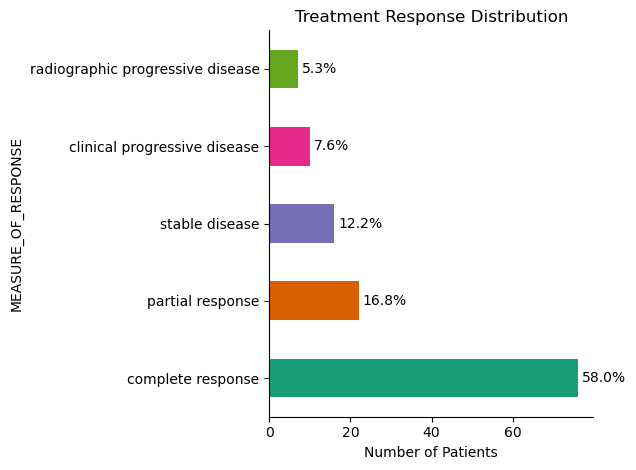

In [57]:
# Count the treatment response categories 
counts = df_clean['MEASURE_OF_RESPONSE'].value_counts()
total = counts.sum()
percentages = (counts / total * 100).round(1)

#Create the bar plot
colors = sns.color_palette('Dark2')
ax = counts.plot(kind = 'barh', color=colors)

#Add percentage labels next to each bar 
for i, (value, percent) in enumerate(zip(counts, percentages)):
    plt.text(value + 1, i, f"{percent}%", va='center')

#clean up plot
ax.spines [['top', 'right']].set_visible(False)
plt.xlabel("Number of Patients")
plt.title("Treatment Response Distribution")
plt.tight_layout()
plt.show()

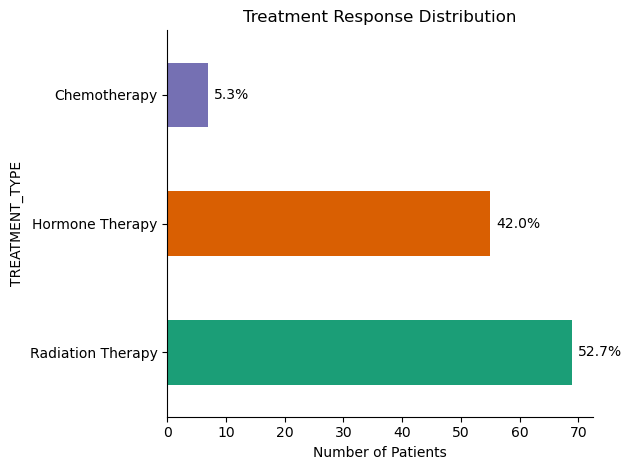

In [59]:
# Count the treatment response categories 
counts = df_clean['TREATMENT_TYPE'].value_counts()
total = counts.sum()
percentages = (counts / total * 100).round(1)

#Create the bar plot
colors = sns.color_palette('Dark2')
ax = counts.plot(kind = 'barh', color=colors)

#Add percentage labels next to each bar 
for i, (value, percent) in enumerate(zip(counts, percentages)):
    plt.text(value + 1, i, f"{percent}%", va='center')

#clean up plot
ax.spines [['top', 'right']].set_visible(False)
plt.xlabel("Number of Patients")
plt.title("Treatment Response Distribution")
plt.tight_layout()
plt.show()